In [1]:
import rdkit
from rdkit import Chem
from rdkit import DataStructs
import collections
from collections import defaultdict
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem

/home/nutzer/miniconda3/envs/chemcharts/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
# CLASS DEFINITION

class Embedding:
    def __init__(self, np_array):
        self.np_array = np_array
        
        
class Fingerprint_Container:
    def __init__(self, name, fingerprint_list):
        self.name = name
        self.fingerprint_list = fingerprint_list
        
    def __repr__(self):
        return f"Name: {self.name}"
        
    def __str__(self):
        return self.__repr__()
    
    def __iter__(self):
        return iter(self.fingerprint_list)
    
    
class Fingerprint_Generator:
    def __init__(self, smiles_list):
        self.mol_list = self.make_mol_list(smiles_list)
        
    def __repr__(self):
        return f"Name: {self.name}"
        
    def __str__(self):
        return self.__repr__()
    
    def __iter__(self):
        return iter(self.fingerprint_list)
    
    @staticmethod
    def make_mol_list(column):
        mol_list = []
        for item in column:
            mol_list.append(Chem.MolFromSmiles(item))
        return mol_list

    def generate_fingerprints(self):
        fingerprint_buffer = []
        for mol in self.mol_list:
            fingerprint = Chem.RDKFingerprint(mol)
            fingerprint_buffer.append(list(fingerprint))
        return Fingerprint_Container(name = "standard_fingerprint", fingerprint_list = fingerprint_buffer)

    def generate_fingerprints_morgan(self, useFeatures=False):
        fingerprint_buffer = []
        for mol in self.mol_list:
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius = 3, useFeatures = useFeatures)
            fingerprint_buffer.append(list(fingerprint))
        return  Fingerprint_Container(name = "morgan_fingerprint_false", fingerprint_list = fingerprint_buffer)

    def generate_fingerprints_maccs(self):
        fingerprint_buffer = []
        for mol in self.mol_list: 
            fingerprint = MACCSkeys.GenMACCSKeys(mol)
            fingerprint_buffer.append(list(fingerprint))
        return Fingerprint_Container(name = "maccs_fingerprint", fingerprint_list = fingerprint_buffer)
       
        
class Smiles:
    def __init__(self, smiles_list):
        if not isinstance(smiles_list, list):
            raise TypeError("Needs to be a list.")
        self.smiles_list = smiles_list
        
        
class Data_Set:
    def __init__(self, name, active_inactive_list, smiles_obj):
        self.name = name
        self.active_inactive_list = active_inactive_list
        self.smiles_obj = smiles_obj
        self.fingerprint_lists = []
        self.embedding_lists = []
        
    def __repr__(self):
        return f"embedding_list: {self.embedding_lists}"
    
    def __str__(self):
        return self.__repr__()
        
    def add_fingerprint(self, fingerprint):
        fingerprint_names = [item.name for item in self.fingerprint_lists]
        if fingerprint.name in fingerprint_names:
            indx = fingerprint_names.index(fingerprint.name)
            self.fingerprint_lists[indx].fingerprint_list = fingerprint.fingerprint_list       
        else:
            self.fingerprint_lists.append(fingerprint)
        
    def add_embedding_list(self, embedding):
        self.embedding_lists.append(embedding)
        
        



In [3]:
# LOAD DATA AND GENERATE COLUMNS_DIC

# load data and generate an object for each molecule
loaded_data = pd.read_csv("../data/DEKOIS2_Dataset_selected.csv")
COX2_smiles = list(loaded_data['Actives'].dropna())+list(loaded_data['Inactives'])
ERBB2_smiles = list(loaded_data['Actives.1'].dropna())+list(loaded_data['Inactives.1'])
QPCT_smiles = list(loaded_data['Actives.2'].dropna())+list(loaded_data['Inactives.2'])

In [4]:
# GENERATE INSTANCES OF SMILES AND DATA_SET CLASSES

# make list of booleans (actives and inactives resp.)
active_inactive_list = [True] *40 + [False] *1200


# generate an instance of the data_set class and set to COX2_set variable
COX2_set = Data_Set(name = "COX2", active_inactive_list = active_inactive_list, smiles_obj = Smiles(COX2_smiles))
ERBB2_set = Data_Set(name = "ERBB2", active_inactive_list = active_inactive_list, smiles_obj = Smiles(ERBB2_smiles))
QPCT_set = Data_Set(name = "QPCT", active_inactive_list = active_inactive_list, smiles_obj = Smiles(QPCT_smiles))
#print(COX2_set.smiles_obj.smiles_list)


In [5]:
# ADD FINGERPRINTS DEFINITION AND CALL

# define function to add fingerprints to data_set
def add_fingerprints(data_set_obj):
    fp_gen = Fingerprint_Generator(data_set_obj.smiles_obj.smiles_list)
    data_set_obj.add_fingerprint(fp_gen.generate_fingerprints())
    data_set_obj.add_fingerprint(fp_gen.generate_fingerprints_morgan())
    data_set_obj.add_fingerprint(fp_gen.generate_fingerprints_maccs())
    
    
# call function to add fingerprints to instances of data_set class
add_fingerprints(COX2_set)
add_fingerprints(ERBB2_set)
add_fingerprints(QPCT_set)    

In [6]:
# print length of fingerprint_lists

#print(len(QPCT_set.fingerprint_lists))


In [6]:
# DIMENSIONAL REDUCTION DEFINITION

# generating array list of fingerprint_lists
def generating_array_list(fingerprint_obj):
    array_list = []
    for fingerprint in fingerprint_obj:
        array = np.array(fingerprint)
        array_list.append(array)
    return array_list


def dimensional_reduction(fingerprint_obj):
    np.random.seed(42)
   
    array_list = generating_array_list(fingerprint_obj)
    
    reducer = umap.UMAP()
    embedding = Embedding(reducer.fit_transform(array_list))
    
    return embedding


def calculate_embedding(data_set_obj):
    for fingerprint_obj in data_set_obj.fingerprint_lists:
        array_list = generating_array_list(fingerprint_obj)
        embedding = dimensional_reduction(array_list)
        data_set_obj.add_embedding_list(embedding)



In [7]:
# call function to add embedding to instances of data_set class
calculate_embedding(COX2_set)
calculate_embedding(ERBB2_set)
calculate_embedding(QPCT_set)



In [9]:
# GENERATE SCATTERPLOTS DEFINITION:
path = "../tests/junk/"

def generate_single_scatterplots(coordinates, data_set_names, bool_mask, fingerprint_names):
    
    area = np.pi*2
    
    plt.scatter(x = coordinates[np.invert(bool_mask),0], y = coordinates[np.invert(bool_mask),1], c="green", s=area)
    plt.scatter(x = coordinates[bool_mask,0], y = coordinates[bool_mask,1], c="red", s=area)
    plt.title(f"{data_set_names} - {fingerprint_names}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(f"{path}{data_set_names} - {fingerprint_names}_ChemChar_Plot.png")
    plt.show()

    
def generate_scatterplots_to_concatenate(fig, gs, coordinates, data_set_names, fingerprint_names, row, column, bool_mask):  
    area = np.pi*1
    plt.gcf().set_size_inches((15, 15))
    
    ax = fig.add_subplot(gs[row, column])
    
    ax.scatter(x = coordinates[np.invert(bool_mask),0], y = coordinates[np.invert(bool_mask),1], c='green', s=area)
    ax.scatter(x = coordinates[bool_mask,0], y = coordinates[bool_mask,1], c='red', s=area)
    
    ax.set_title(f"{data_set_names} - {fingerprint_names}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.savefig(f"{path}ChemChar_Plot.png")
    

def generate_chemchar_scatterplot(data_sets, scatterplot_type = "single_scatterplots"):
    fig = plt.figure()
    n_rows = len(data_sets[0].fingerprint_lists)
    n_columns = len(data_sets)
    gs = fig.add_gridspec(n_rows, n_columns)
    
    for ind_sets in range(n_columns):
        data_set_names = data_sets[ind_sets].name

        for ind_embedding in range(n_rows):
            embedding = data_sets[ind_sets].embedding_lists[ind_embedding]
            fingerprint_names = data_sets[ind_sets].fingerprint_lists[ind_embedding].name
            bool_mask = np.array(data_sets[ind_sets].active_inactive_list)
            
            if scatterplot_type == "single_scatterplots":
                generate_single_scatterplots(embedding.np_array, data_set_names, bool_mask, fingerprint_names)
            elif scatterplot_type == "concatenated_scatterplots":
                generate_scatterplots_to_concatenate(fig, gs, embedding.np_array, data_set_names, fingerprint_names, ind_embedding, ind_sets, bool_mask)
                fig.show()
            else:
                print("fail!!!!!")

/home/nutzer/miniconda3/envs/chemcharts/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


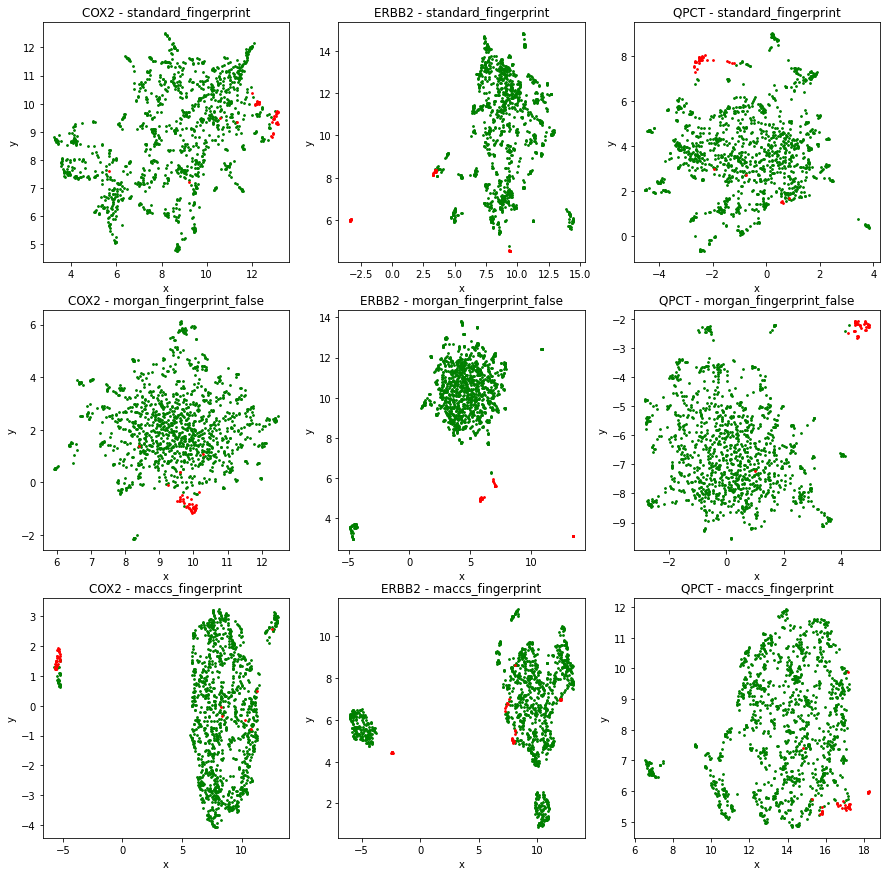

In [10]:
# call function to generate scatterplott
data_sets = [COX2_set, ERBB2_set, QPCT_set]

# choose scatterplot_type: "single_scatterplots" or "concatenated_scatterplots" 
chemchar_scatterplot = generate_chemchar_scatterplot(data_sets = data_sets, 
                                                     scatterplot_type = "concatenated_scatterplots")

#print(len(chemchar_dic["fingerprints"]))

In [ ]:
# show image of molecule structure
m = Chem.MolFromSmiles('COc1ccc(-c2c(-c3ccc(S(C)(=O)=O)cc3)[nH]c3ccccc23)cc1N#Cc1ccnc(N2CCN(c3nc(-c4cccnc4)nc4sc5c(c34)CCC5)CC2)c1')
#print(m)
#m